# Sampling Distribution of the Mean

## Agenda

- Introduction to sampling distributions of statistics and the sampling distribution of the mean
- Law of Large Numbers
- Bootstrap Sampling
- Central Limit Theorem

In [1]:
import numpy as np
import helper

import matplotlib.pyplot as plt
%matplotlib inline

## Sampling Distributions of Statistics

> Suppose we have $n$ independent and identically distributed (i.i.d.) copies of a random variable $X_1, X_2, \ldots, X_n$.

There are many ways to get in this position:
- A random survey of humans is an i.i.d. sample of all humans of interest to the survey designers
- A dataset of all the quotes received for an insurance product is an i.i.d. sample of all possible customers of the insurance company
- Driving around a city and turning a random direction at each intersection is an i.i.d. sample of all possible paths driven through the city (as long as you start in a random place)

Definition

> A **statistic** is a function of the random sample $g(X_1, X_2, ..., X_n)$.  A simple and common statistic is the **sample mean** defined by $\frac{1}{n} \sum_{i=1}^n X_i$.

A statistic is itself a random variable: Its variation comes from the different samples drawn from the random variable.

To quantify the amount of variation of a statistic, we need a process like this:
- Draw a random sample of size $n$ from $X$ (i.i.d.)
- Compute the sample statistic and record it
- Do it again and again

Definition

> The **distribution of the statistic** that arises from this process is called the **sampling distribution of the statistic**.  E.g., **the distribution of the sample means** is the **sampling distribution of the mean**.

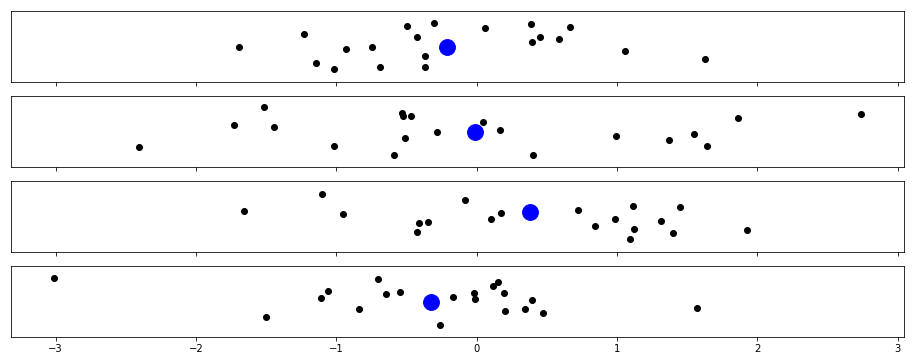

In [2]:
population = helper.Normal(0, 1)
sample_sizes = [20] * 4
samples = [population.sample(sample_size) for sample_size in sample_sizes]

_, axs = plt.subplots(4, 1, figsize=(16, 6), sharex=True)

for sample, ax in zip(samples, axs.flatten()):
    helper.scatterplot(sample, ax=ax)
    ax.scatter(np.mean(sample), 0, c='blue', s=250)

(**samples** in black; **sample means** in blue)

Notice that, the spread of the sampling distribution is much smaller than that of the samples.

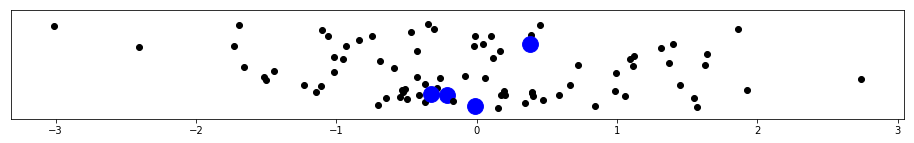

In [3]:
_, ax = plt.subplots(1, 1, figsize=(16, 2))

for sample in samples:
    helper.scatterplot(sample, ax=ax)
    helper.scatterplot([np.mean(sample)], c='blue', s=250, ax=ax)

Questions:
- What's the *average value* of the **sample mean**?
- How much does it *vary around* its *average value*?

## Law of Large Numbers (LLN)

Definitions

- If $X$ is a discrete random variable with $k$ possible outcomes and $P(X = x_i)$ the value of its probability mass function at $x_i$, then the expected value of $X$ (or **population mean**) is the *theoretical* quantity computed by the following sum:

$$E[X] = \sum_{i=1}^k x_i P(X = x_i)$$

- The **sample mean** of a set of *data* (often postulated to result from an i.i.d. sample from a random variable) of size $n$ is the *practical* quantity computed as the following sum:

$$\frac{1}{n} \sum_{i=1}^n X_i$$

These two concepts are just *definitions*.  The fundamental connection between them is given by the **Law of Large Numbers**:

> Suppose that $X_i$ are i.i.d. copies of a random variable $X$.  Then, for $n$ sufficiently large, the **sample mean** computed from a sample of size $n$ is approximately equal to the **population mean**:
>
> $$\frac{1}{n} \sum_{i=1}^n \approx E[X]$$

*(More precisely, as $n$ get larger, the probability of seeing a sample mean different from the population mean goes to zero)*

### Example

Suppose that $X \sim \text{Bernoulli}(p = .5)$.  In the plot below, we draw samples of increasing size from $X$, and compute the corresponding sample mean.  According to the LLN, these paths of **sample means** should all limit towards the **population mean** of $p = .5$.

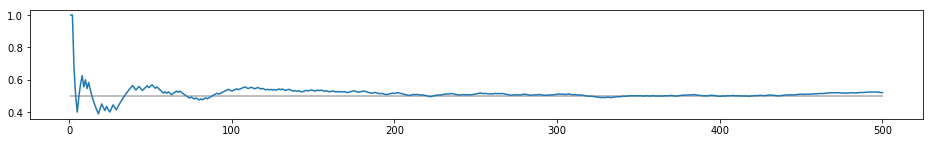

In [4]:
population = helper.Binomial(1, .5)
sample_sizes = [500] * 10
samples = [population.sample(sample_size) for sample_size in sample_sizes]

sample_sizes, sample_means = helper.sample_means(samples[0])

_, ax = plt.subplots(1, 1, figsize=(16, 2))

ax.plot(sample_sizes, np.repeat(.5, len(sample_sizes)), linewidth=2, c='grey', alpha=.5)
ax.plot(sample_sizes, sample_means)

Note that the LLN does **not** say that the number of 0's sampled becomes equal to the number of 1's sampled as $n$ grows, *only that their differences become less noticeable over time with respect to the magnitude of numbers involved*.  In fact, if you plot many of these curves on one graph, you can see that in aggregate, they spread out over time.

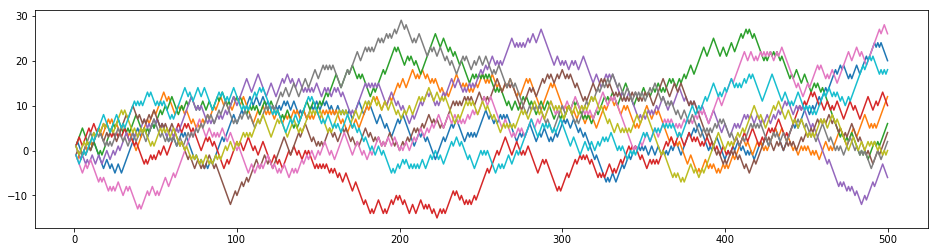

In [5]:
_, ax = plt.subplots(1, 1, figsize=(16, 4))

for sample in samples:
    sample_sizes, sample_differences = helper.sample_differences(sample)
    ax.plot(sample_sizes, sample_differences)

LLN tells us that the **sample mean** is an estimate of the **population mean**.

Follow-up question:
- How *accurate* of an estimate of the **population mean** is the **sample mean**?

## The Sampling Distribution of the Mean

Recall our observation that the sample mean has less variance than the sample itself.  It is actually possible to quantify it:

$$Var \left[ \bar{X} \right] = Var \left[ \frac{1}{n} (X_1 + X_2 + \cdots + X_n) \right] = \frac{1}{n^2} Var[X_1 + X_2 + \cdots + X_n] = \frac{1}{n^2} (n Var[X]) = \frac{1}{n} Var[X]$$

(no covariance terms since we have an i.i.d. sample)

Question: What's the expectation of the **sample means**?

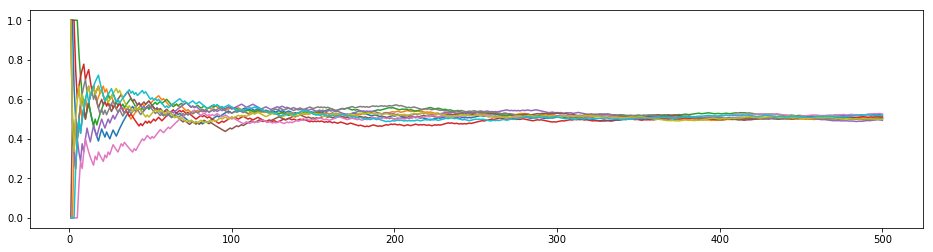

In [6]:
_, ax = plt.subplots(1, 1, figsize=(16, 4))

for sample in samples:
    sample_sizes, sample_means = helper.sample_means(sample)
    ax.plot(sample_sizes, sample_means)

It is hard to verify this computation in any concrete specific situation: We generally have one fixed dataset, which we view as a *single* sample from the population.  **The population is the object that interests us, and the sample is the lens through which we get to view it.**

Question: Given this, can we construct a distribution, using a sample, that is the *best possible* approximation of the population distribution?

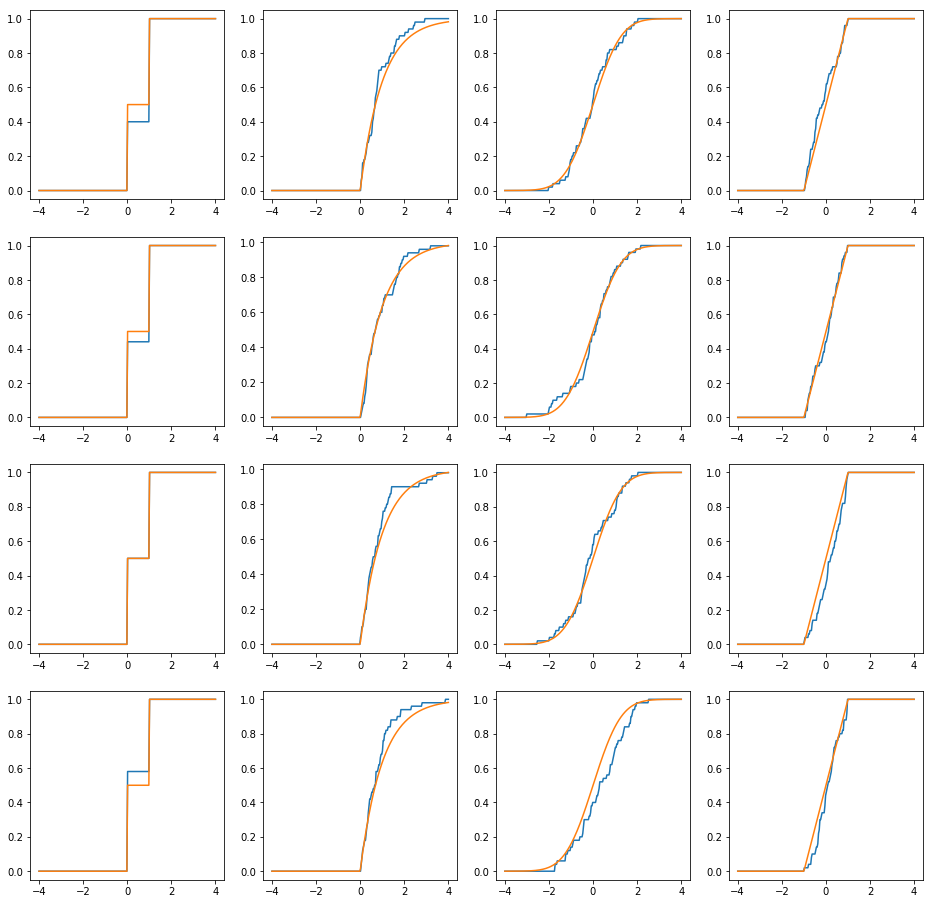

In [7]:
populations = [helper.Binomial(1, .5), helper.Exponential(1),
    helper.Normal(0, 1), helper.Uniform(-1, 1), ] * 4

_, axs = plt.subplots(4, 4, figsize=(16, 16))

for population, ax in zip(populations, axs.flatten()):
    sample = population.sample(50)
    x = np.linspace(-4, 4, num=250)
    ax.plot(x, helper.empirical_cdf(x, sample))
    ax.plot(x, population.cdf(x))

Now, of course, we usually **cannot repeatedly sample from the population**, that is **we usually have only one sample**.

## Bootstrap Sampling

### The Big Idea

> We want to estimate the variance of the sample means by **repeatedly sampling from the *population***, computing the sample means of these samples, and then computing the variance of the multiple sample means.

But we can't, because we can only sample from the population **once**.

> Intead, we estimate the variance of the sample means by **repeatedly sampling from a *distribution best approximating the population distribution***, computing the sample means of these samples, and then computing the variance of the multiple sample means.

The **distribution best approximating the population distribution** is the **empirical distribution of the sample**

### Definition

A **bootstrap sample** from a dataset is a sample taken *with replacement* from that dataset whose size is the size of the dataset itself.

In [8]:
data = helper.dataset()

b = 100

bootstrap_samples = [np.random.choice(data, size=len(data), replace=True) for _ in range(b)]

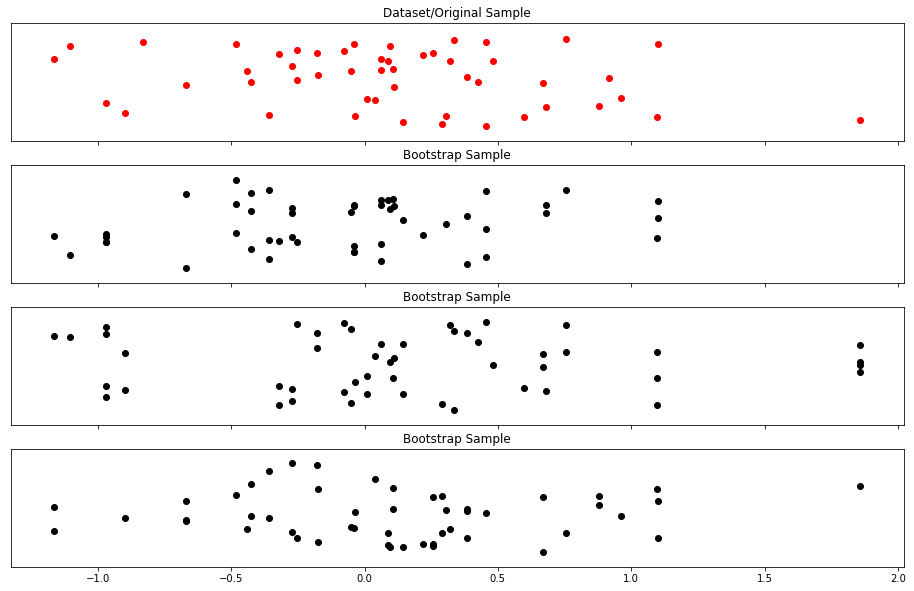

In [9]:
_, axs = plt.subplots(4, 1, figsize=(16, 10), sharex=True)
axs = axs.flatten()

helper.scatterplot(data, axs[0], c='red')
axs[0].set_title('Dataset/Original Sample')

for bootstrap_sample, ax in zip(bootstrap_samples, axs[1:]):
    helper.scatterplot(bootstrap_sample, ax)
    ax.set_title('Bootstrap Sample')

Each bootstrap sample has its *own* **sample mean**:

In [10]:
bootstrap_means = [np.mean(bootstrap_sample) for bootstrap_sample in bootstrap_samples]

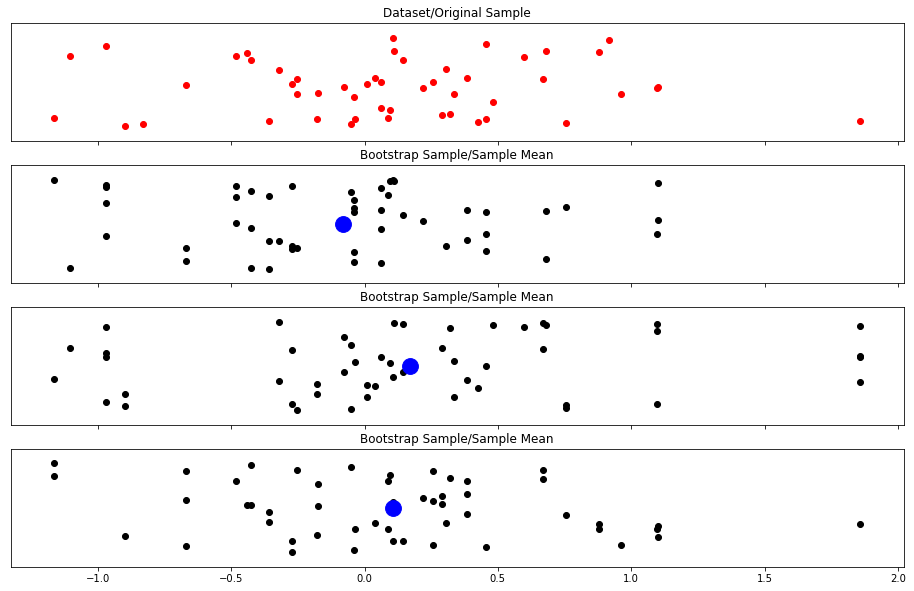

In [11]:
_, axs = plt.subplots(4, 1, figsize=(16, 10), sharex=True)
axs = axs.flatten()

helper.scatterplot(data, axs[0], c='red')
axs[0].set_title('Dataset/Original Sample')

for bootstrap_sample, bootstrap_mean, ax in zip(bootstrap_samples, bootstrap_means, axs[1:]):
    helper.scatterplot(bootstrap_sample, ax)
    ax.scatter(bootstrap_mean, 0, c='blue', s=250)
    ax.set_title('Bootstrap Sample/Sample Mean')

The **sample means** taken from repeated bootstrap samples are then an approximation to the **distribution of the sample means**.

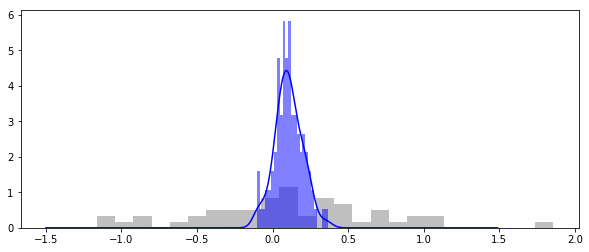

In [12]:
_, ax = plt.subplots(1, figsize=(10, 4))

ax.hist(data, bins=25, normed=True, color='black', alpha=.25)
ax.hist(bootstrap_means, bins=25, normed=True, color='blue', alpha=.5)

density = helper.density(bootstrap_means)
x = np.arange(-1.5, 1.5, .01)

ax.plot(x, density(x), c='blue');

Clearly, the variance of the sample means is *much* smaller than the variance of the data.

In [13]:
sample_var = np.var(data)
bootstrap_means_var = np.var(bootstrap_means)

print 'Var[X]: {:2.2f}'.format(sample_var)
print 'Var[X_bar]: {:2.2f}'.format(bootstrap_means_var)
print 'Ratio: {:2.2f}'.format(sample_var/bootstrap_means_var)
print 'n = {}'.format(len(data))

Var[X]: 0.36
Var[X_bar]: 0.01
Ratio: 43.29
n = 50


The variance of the sample means of the bootstrap samples is then an estimate of the variance of the sample mean.  This is consistent with our calculation above: $n = \frac{Var[X]}{Var[\bar{X}]}$

## Central Limit Theorem (CLT)

The bootstrap works for approximating the sampling distribution of **any statistic**.  Its flexibility makes it a fundamental tool in the box of any data scientist.  However, the **distribution of the sample means** is the special case where the **Central Limit Theorem** superseds bootstrapping.

Suppose $X_1, X_2, \ldots$ are i.i.d. copies of a random variable with finite expectation and variance.

$$E[X_1] = E[X_2] = \cdots = \mu$$
$$Var[X_1] = Var[X_2] = \cdots = \sigma^2$$

Then the **distribution of the sample means** tends to a normal distribution with the appropriate mean and standard deviation:

$$\bar{X} = \frac{1}{n} \sum_{i=1}^{n} X_i \rightarrow N \left( \mu, \frac{\sigma^2}{n} \right) \text{ as } n \rightarrow \infty$$

The stunning part of the CLT is that it makes almost no assumptions about $X$.  $X$ can be anything and its sample means will always tend to be normal.

If the CLT needed an elevator pitch statement.  It would be:
> **The central limit theorem allows us to make probabilistic statements about the sample mean from any population using the normal distribution**



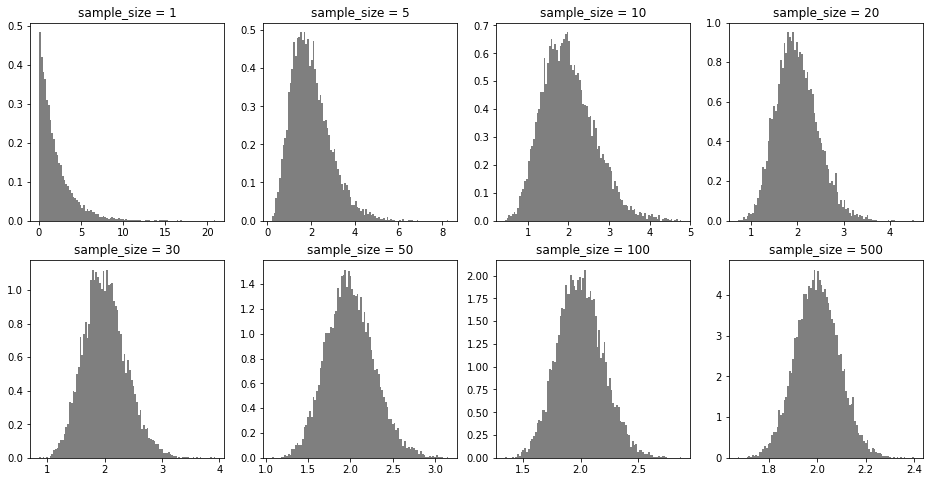

In [14]:
population = helper.Exponential(2)

size_of_sample = [1, 5, 10, 20, 30, 50, 100, 500]

_, axs = plt.subplots(2, 4, figsize=(16, 8))

for sample_size, ax in zip(size_of_sample, axs.flatten()):
    n_samples = 10000
    samples = population.sample(n_samples*sample_size).reshape(n_samples, sample_size)
    sample_means = np.sum(samples, axis=1) / sample_size

    ax.hist(sample_means, bins=100, normed=True, color='black', alpha=0.5)
    ax.set_title('sample_size = {}'.format(sample_size))